In [23]:
from phi.torch.flow import *
import matplotlib.pyplot as plt

from src.eigenfluid import Eigenfluid

# Helper functions for visualization
from src.visu import *

import time

In [24]:
# Number of basis fields
N = 4**2 
# Domain sizes
DOMAIN = Box(x=math.PI, y=math.PI)
SAMPLING_SIZE = 32

start_time = time.time()
eigenfluid = Eigenfluid(N, DOMAIN, SAMPLING_SIZE)
end_time = time.time()
print("Eigenfluid initialized in {} seconds".format(end_time-start_time))

Eigenfluid initialized in 9.555973768234253 seconds


In [ ]:
'''
velocity = eigenfluid.reconstruct_velocity()
smoke = CenteredGrid(Box(x=[1,2], y=[1,2]), 
                     extrapolation.BOUNDARY, 
                     x=100, y=100, 
                     bounds=DOMAIN)

vis.plot({
    "Initial Smoke": smoke,
    "Initial Velocity": get_rescaled_vel(velocity),
    "Initial Curl": field.curl(velocity),
    "Initial w (*100)": get_w_point_cloud(eigenfluid.w * 100)
}, same_scale = False)
'''

# Reference Simulations

In [25]:
velocity = eigenfluid.reconstruct_velocity()

trajectory_v = [velocity]
trajectory_curl = [field.curl(velocity)]

STEPS = 16
DT = 0.2

w_0 = eigenfluid.w

start_time = time.time()
for i in range(STEPS):
    # For grid-based simulation:
    #velocity = advect.semi_lagrangian(velocity, velocity, dt=DT)
    #velocity, _ = fluid.make_incompressible(velocity)
    eigenfluid.w = eigenfluid.step_w_euler(eigenfluid.w, DT)
    
    curr_vel = eigenfluid.reconstruct_velocity()
    trajectory_v.append(curr_vel)
    trajectory_curl.append(field.curl(curr_vel))
end_time = time.time()
print("Simulation finished in {} seconds".format(end_time-start_time))

trajectory_v_ref = math.stack(trajectory_v, batch('time'))
trajectory_curl_ref = math.stack(trajectory_curl, batch('time'))

v_target = eigenfluid.reconstruct_velocity()

Simulation finished in 1.1867198944091797 seconds


# Gradients from Eigenfluid simulation

In [27]:
def loss_function(w):
    eigenfluid.w = w
    #velocities = [eigenfluid.reconstruct_velocity()]
    for t in range(STEPS):
        eigenfluid.w = eigenfluid.step_w_euler(eigenfluid.w, DT)
        #velocities.append(eigenfluid.reconstruct_velocity())
    loss = field.l2_loss(eigenfluid.reconstruct_velocity() - v_target)
    return loss#, velocities

gradient_function = math.gradient(loss_function)

loss, grad = gradient_function(w_0)
print("Loss: {}".format(loss))

Loss: 0.0


# Optimize for Unknown initial w
Now we would like to find an initial w vector such that it lines up with the target simulation after STEPS number of iterations.

In [34]:
# Initialize w to some value for optimization (random or 0)
#w_init = math.zeros_like(eigenfluid.w)
w_init = math.random_normal(eigenfluid.w.shape)

# first gradient
loss, grad = gradient_function(w_init)
print("Loss: {}".format(loss))

Loss: 604.2629


## Optimization

In [1]:
LR = 0.001

#w_optim = w_init
grads = []
for optim_step in range(163):
    loss, grad = gradient_function(w_optim)
    if optim_step%10 == 0 or optim_step < 5:
        print("Optimization step %d, loss: %f" % (optim_step, loss))
    grads.append( grad[0] )
    
    w_optim = w_optim - LR * grads[-1]

NameError: name 'gradient_function' is not defined

<Figure size 1200x500 with 2 Axes>

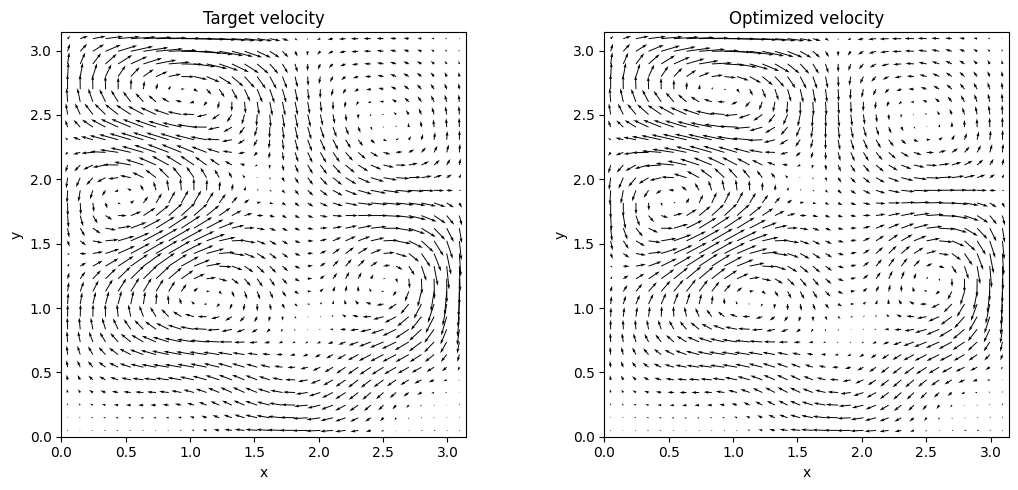

In [36]:
plot({"Target velocity": v_target, "Optimized velocity": eigenfluid.reconstruct_velocity()})

<Figure size 1200x500 with 3 Axes>

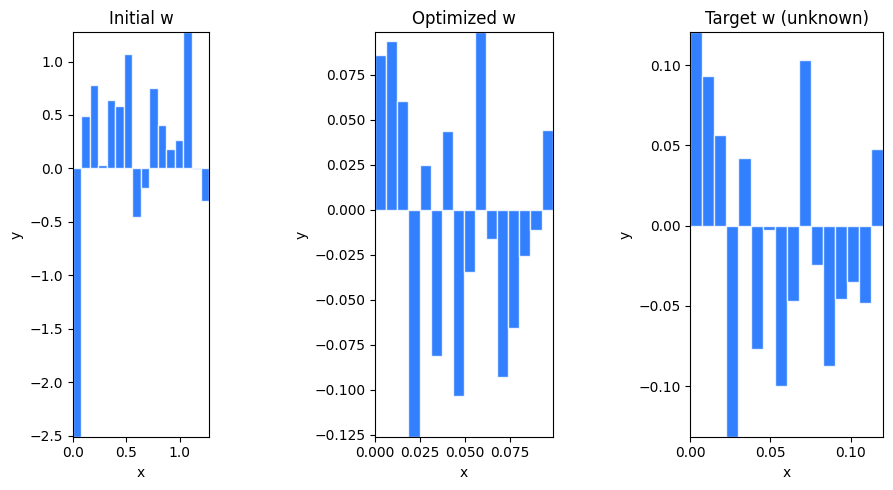

In [37]:
plot({
    "Initial w": get_w_point_cloud(w_init),
    "Optimized w": get_w_point_cloud(w_optim),
    "Target w (unknown)": get_w_point_cloud(w_0)
})